# Prototyping Models w/ PyTorch

## Setup

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets
import sklearn.linear_model
import torch
from torch.nn import Linear, ReLU, MSELoss

from chmp.ds import mpl_set
from chmp.torch_utils.nn import linear
from chmp.torch_utils.model import Model

RUNNING_AS_TEST = os.environ.get("PYTEST_CURRENT_TEST") is not None

In [2]:
# create a regression data set
x, y = sklearn.datasets.make_regression(
    n_samples=1_000, 
    n_features=10, 
    n_informative=2, 
    shuffle=False, 
    random_state=42_42_42,
)

# with redudant features
x = np.concatenate([x, x], axis=1)
n_samples, n_features = x.shape

In [3]:
print(f"number of samples: {n_samples}")
print(f"number of features {n_features}")

number of samples: 1000
number of features 20


## Linear regression model with horeshoe prior

See C. Louizos, K. Ullrich, and M. Welling, "[Bayesian Compression for Deep Learning](https://arxiv.org/abs/1705.08665)" (2017).

Use Horseshoe prior on the weights:

$$
\begin{align}
    s_a \sim &\mathcal{G}(0, \tau_0^2) \\
    s_b^{-1} &\sim \mathcal{G}(0, 1/2) \\
    \alpha_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \beta^{-1}_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \tilde{w}_{ij} &\sim \mathcal{N}(0, 1) \\
    w_{ij} &= \tilde{w}_{ij} \sqrt{s_a / s_b} \sqrt{\alpha / \beta}
\end{align}
$$

Use the variational approximation:
$$
\begin{align}
    q(s_a) &= \mathcal{LN}(\dots) \\
    q(s_b^{-1}) &= \mathcal{LN}(\dots) \\
    q(\alpha_{ij}) &= \mathcal{LN}(\dots) \\
    q(\beta_{ij}^-{1}) &= \mathcal{LN}(\dots) \\
    q(\tilde{w}_{ij}) &= \mathcal{N}(\dots) \\
\end{align}
$$

In [4]:
from chmp.torch_utils.bayes import WeightsHS, NormalModelConstantScale, SimpleBayesModel

In [5]:
class LinearHS(NormalModelConstantScale):
    def __init__(self, in_features, out_features, tau_0, bias=True):
        super().__init__()
        
        self.weights = WeightsHS((in_features, out_features), tau_0=tau_0)
        self.bias = torch.nn.Parameter(torch.zeros(1)) if bias else 0
        
    def transform(self, x):
        return self.bias + linear(x, self.weights())
    
    def kl_divergence(self):
        return self.weights.kl_divergence()
    
    
def mse_loss(pred, y):
    loc, _ = pred
    return torch.mean((loc - y) ** 2.0)

In [6]:
model = SimpleBayesModel(
    module=LinearHS(n_features, 1, tau_0=1e-5),
    n_observations=n_samples,
    optimizer_kwargs=dict(lr=1e-2),
)

history = model.fit(
    x, y, 
    epochs=500 if not RUNNING_AS_TEST else 1, 
    verbose=True,
    metrics=[mse_loss],
    validation_data=(x, y),
    dtype='float32',
)
y_pred_loc, y_pred_scale = model.predict(x.astype('float32'))

linear_coefs = sklearn.linear_model.LinearRegression().fit(x, y).coef_
weights = np.concatenate([model.module.weights().detach().numpy() for _ in range(100)], axis=1)

[done. took 2m 33s] 128 mse_loss: 3.96 (499 / 500)                                                                      



/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


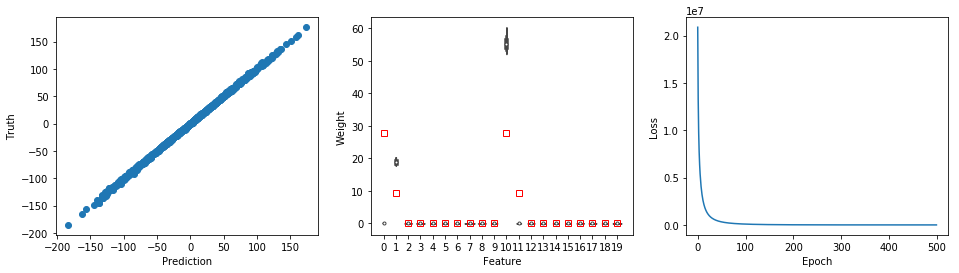

In [7]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

plt.sca(ax1)
plt.scatter(y_pred_loc, y)
mpl_set(xlabel="Prediction", ylabel="Truth")

plt.sca(ax2)

sns.violinplot(data=weights.T)
plt.plot(linear_coefs, 's', markeredgecolor='r', markerfacecolor='none')
mpl_set(xlabel="Feature", ylabel="Weight")

plt.sca(ax3)
plt.plot(history.get('epoch'), history.get('loss'))
mpl_set(xlabel="Epoch", ylabel="Loss")

## Attention

Use an attention model of the form

$$
\begin{align}
    \alpha_{ij} &= q(x_i)^T k(x_j) \\
    p_{ij} &= \mathrm{softmax}(\alpha_{ij}, \mathrm{mask}) \\
    \hat{y}_i &= \sum_j p_{ij} v(x_j, y_j)
\end{align}
$$

In [8]:
from chmp.torch_utils.attention import Transformer

In [9]:
def transform_x(idx):
    mask = np.ones(len(x))
    mask[idx] = 0
    
    return {
        'query_x': x[idx].astype('float32'),
        'mask': mask
    }


def transform_xy(idx):
    batch_x = transform_x(idx)
    batch_y = y[idx].astype('float32') 
    return batch_x, batch_y

In [10]:
model = Model(
    module=Transformer(
        key_module=torch.nn.Sequential(
            Linear(n_features, 20),
            ReLU(),
            Linear(20, 20),
            ReLU(),
        ),
        search_x=x.astype('float32'), 
        search_y=y.astype('float32'),
    ),
    loss=MSELoss(),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=1e-2),
)

history = model.fit_transformed(
    transform_xy, 
    range(len(x)), 
    batch_size=20, 
    dtype=None, 
    epochs=10 if not RUNNING_AS_TEST else 1, 
    verbose=True,
)
y_pred = model.predict_transformed(transform_x, range(len(x)), batch_size=20, dtype=None, verbose=True)

[done. took 4.95s] 11.1 (9 / 10)                                                                                        

[done. took 0.25s] predict                                                                                              



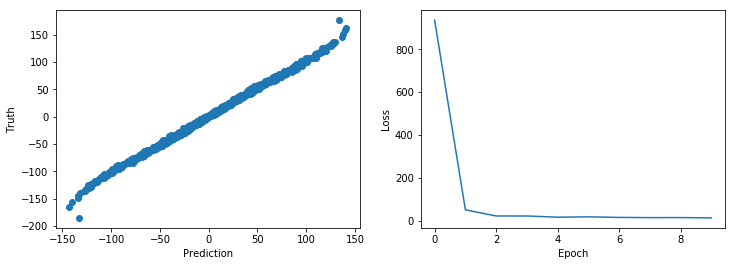

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(ax1)
plt.scatter(y_pred, y)
mpl_set(xlabel="Prediction", ylabel="Truth")

plt.sca(ax2)
plt.plot(history.get('epoch'), history.get('loss'))
mpl_set(xlabel="Epoch", ylabel="Loss")